# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: The importance of equal batch sizes
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [36]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

/tmp/ipykernel_6866/2120876513.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


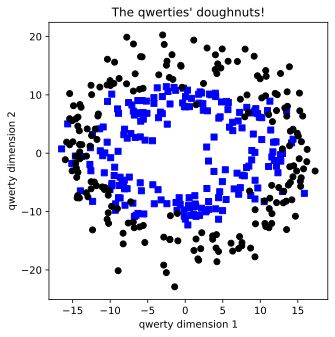

In [37]:
# Set the number of data points per cluster.
nPerClust = 200

# Create an array 'th' representing angles from 0 to 4*pi.
th = np.linspace(0, 4*np.pi, nPerClust)

# Set radii for two clusters.
r1 = 10
r2 = 15

# Generate data for the first cluster 'a'.
a = [r1*np.cos(th) + np.random.randn(nPerClust)*3,
     r1*np.sin(th) + np.random.randn(nPerClust)]

# Generate data for the second cluster 'b'.
b = [r2*np.cos(th) + np.random.randn(nPerClust),
     r2*np.sin(th) + np.random.randn(nPerClust)*3]

# Create true labels. '0' for the first cluster, '1' for the second.
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

# Concatenate 'a' and 'b' data into a single matrix 'data_np'.
data_np = np.hstack((a, b)).T

# Convert 'data_np' and 'labels_np' into PyTorch tensors.
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# Visualize the data.
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs')
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], 'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()


# Separate the data into DataLoaders

In [38]:
# Split the data into training and testing sets using scikit-learn's train_test_split function.
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.1)

# Convert the training and testing data and labels into PyTorch TensorDatasets.
train_data = TensorDataset(train_data, train_labels)
test_data  = TensorDataset(test_data, test_labels)

# Define batch sizes for the data loaders.
# 'train_batchsize' is the batch size for training, and 'test_batchsize' is for testing.
train_batchsize = 16
test_batchsize  = test_data.tensors[0].shape[0] - 2  # Set test batch size slightly smaller for demonstration purposes.

# Create DataLoader objects for training and testing data.
# - 'train_loader' will shuffle the training data and drop the last batch if its size is less than 'train_batchsize'.
# - 'test_loader' will use 'test_batchsize' for testing.
train_loader = DataLoader(train_data, batch_size=train_batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_data, batch_size=test_batchsize)


In [39]:
# check sizes of data batches
for X,y in test_loader:
  print(X.shape,y.shape)

torch.Size([38, 2]) torch.Size([38, 1])
torch.Size([2, 2]) torch.Size([2, 1])


# Model stuff

In [40]:
# Define a custom neural network class named 'theModelClass' that inherits from nn.Module.
class theModelClass(nn.Module):
  def __init__(self):
    super().__init__()

    ### layers
    # Define the layers of the neural network:
    # - 'input': Linear layer with input size 2 and output size 128.
    # - 'hidden': Linear layer with input size 128 and output size 128.
    # - 'output': Linear layer with input size 128 and output size 1.
    self.input  = nn.Linear(2, 128)
    self.hidden = nn.Linear(128, 128)
    self.output = nn.Linear(128, 1)

  # Define the forward pass of the neural network.
  def forward(self, x):
    # Apply the ReLU activation function to the output of the 'input' layer.
    x = F.relu(self.input(x))
    
    # Apply the ReLU activation function to the output of the 'hidden' layer.
    x = F.relu(self.hidden(x))
    
    # The final output is obtained from the 'output' layer without an activation function.
    x = self.output(x)
    return x


In [41]:
# Define a function named 'createANewModel' that creates an instance of the custom neural network model, sets the loss function, and optimizer.

def createANewModel():
  # Create an instance of the custom neural network model 'theModelClass' that you defined earlier.
  ANNQC = theModelClass()

  # Define the loss function as Binary Cross-Entropy with Logits Loss.
  # This loss function is suitable for binary classification tasks.
  lossfun = nn.BCEWithLogitsLoss()

  # Define the optimizer for training the neural network.
  # Here, Stochastic Gradient Descent (SGD) optimizer is used with a learning rate of 0.01.
  optimizer = torch.optim.SGD(ANNQC.parameters(), lr=0.01)

  # Return the created neural network, loss function, and optimizer.
  return ANNQC, lossfun, optimizer


In [42]:
# Define a global parameter 'numepochs' which represents the number of training epochs.
# In this case, it's set to 500.

numepochs = 500

# Define a function named 'trainTheModel' that trains the neural network model.
# This function takes three inputs: 'ANNQC' (the model), 'lossfun' (the loss function), and 'optimizer' (the optimizer).

def trainTheModel(ANNQC, lossfun, optimizer):
  # Initialize lists to store training and test accuracies for each epoch.
  trainAcc = []  # Training accuracies
  testAcc = []   # Test accuracies

  # Loop over training epochs
  for epochi in range(numepochs):

    # Initialize a list to store batch accuracies for each batch within an epoch.
    batchAcc = []

    # Loop over training data batches using 'train_loader'
    for X, y in train_loader:

      # Forward pass: compute predictions 'yHat' and calculate the loss using 'lossfun'.
      yHat = ANNQC(X)
      loss = lossfun(yHat, y)

      # Backpropagation: zero gradients, calculate gradients, and update model parameters using 'optimizer'.
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy for the current batch and append it to 'batchAcc'.
      # Here, we check if predictions 'yHat' are greater than 0, assuming a binary classification task.
      batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
    # End of batch loop...

    # Calculate the average training accuracy for the current epoch and append it to 'trainAcc'.
    trainAcc.append(np.mean(batchAcc))

    # Test accuracy (NOTE: testing in batches!)
    tstacc = []

    # Loop over test data batches using 'test_loader'
    for X, y in test_loader:

      # Forward pass: compute predictions 'yHat' for the test batch.
      yHat = ANNQC(X)

      # Compute test accuracy for the current batch and append it to 'tstacc'.
      tstacc.append(100 * torch.mean(((yHat > 0) == y).float()).item())

    # Calculate the average test accuracy for the current epoch and append it to 'testAcc'.
    testAcc.append(np.mean(tstacc))
  
  # Function output: Return the lists of training and test accuracies.
  return trainAcc, testAcc



# Application

In [43]:
# Create a new neural network model, loss function, and optimizer using the 'createANewModel' function.
# 'createANewModel' returns three values: the model ('ANNQC'), loss function ('lossfun'), and optimizer ('optimizer').

# Create the model architecture, loss function, and optimizer.
ANNQC, lossfun, optimizer = createANewModel()

# Train the model using the 'trainTheModel' function.
# Pass the model ('ANNQC'), loss function ('lossfun'), and optimizer ('optimizer') as inputs to the function.

# The function returns two lists: 'trainAcc' (training accuracies) and 'testAcc' (test accuracies).
trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)


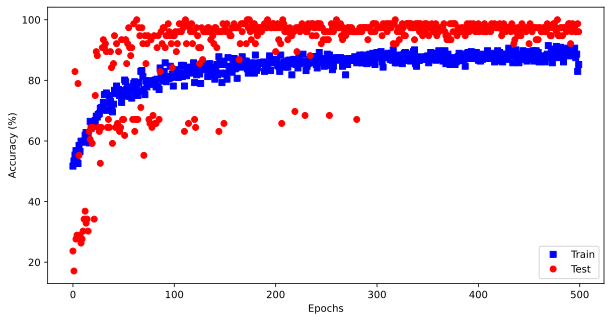

In [44]:
# Create a new figure for plotting with a specified size (10 units in width and 5 units in height).
fig = plt.figure(figsize=(10,5))

# Plot the training accuracies as blue squares ('bs').
plt.plot(trainAcc,'bs')

# Plot the test accuracies as red circles ('ro').
plt.plot(testAcc,'ro')

# Set the x-axis label to 'Epochs'.
plt.xlabel('Epochs')

# Set the y-axis label to 'Accuracy (%)'.
plt.ylabel('Accuracy (%)')

# Create a legend for the plot, labeling the blue squares as 'Train' and the red circles as 'Test'.
plt.legend(['Train','Test'])

# Display the plot.
plt.show()
